# Module 1 Project: King County House Sales Price Projection


#### Follow the OSEMN model process in this project:

- **  Obtain **
- **  Scrub **
- **  Explore **
- **  Model **
- **  Interpret **

# I. Obtain the data 


In [1]:
#import libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from collections import Counter

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
kcdata = pd.read_csv("kc_house_data.csv")

In [3]:
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
kcdata.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# II. Data Scrubbing



* Identify and deal with null values appropriately
* Cast columns to the appropriate data types
* Remove unnecessary columns
* Check for and deal with multicollinearity
* Normalize our data

### Deal with missing values

In [7]:
#Identify missing value: waterfront, view, yr_renovated, and incorrect data type: sqft_basement
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [8]:
kcdata.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
#For Categorical data 'Waterfront', replace NAN with mode 0 since it is highly possible that the house doesn't have a waterfront. 
kcdata['waterfront'].value_counts()
kcdata['waterfront'] = kcdata['waterfront'].fillna(0)

counter = Counter()
counter = Counter(kcdata['waterfront'])
print(counter)

Counter({0.0: 21451, 1.0: 146})


For view, this variable presents how many times people have viewed the house. Majority of the values are zero. So we will replace NAN with 0.

In [11]:
kcdata['view'].unique()
kcdata['view'] = kcdata['view'].fillna(0)
counter = Counter()
counter = Counter(kcdata['view'])
print(counter)


Counter({0.0: 19485, 2.0: 957, 3.0: 508, 1.0: 330, 4.0: 317})


In [9]:
#There are too many missing values in yr_renovated. And it may not be fair to replace NAN with average. 
#So we will probably not consider this variable into the model.We will fill NaN and remove this column now.
%matplotlib inline
kcdata['yr_renovated'].fillna(0);
kcdata = kcdata.drop('yr_renovated', axis =1);
#kcdata['yr_renovated'].hist()

In [12]:
kcdata.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233181,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.764673,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [13]:
kcdata.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Cast columns to the appropriate data types

Obvious fix: change date from string to datetime, sqft_basement to continuous, waterfront as categorical

Condition and grade are ordinal variables with limited values. View and Floors have limited values too. Can group them into bins. 

In [12]:
#Convert strings into dates
from datetime import datetime
kcdata['date'].head()
f = lambda x: datetime.strptime(x,'%m/%d/%Y')
kcdata['date']=kcdata['date'].apply(f)
kcdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503


In [13]:
#Convert sqft_basement column from string to numerical
kcdata['sqft_basement'].value_counts()

#Replace ? with zeros for now.
kcdata['sqft_basement'] = kcdata['sqft_basement'].replace('?','0')


kcdata['sqft_basement'] = kcdata['sqft_basement'].astype(float)
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11)
memory usage: 3.3 MB


## Part II: Exploratory Data Analysis

From the data dictionary below we can probably tell some are continuous variables (footage of the home/lot/basement/yr_built) and some might be numerical but more like categorical (number of bathrooms/bedrooms, waterfront, view, condition, grade), and other variables we are not sure (zipcode,lat,long). We will visualize them next.

* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

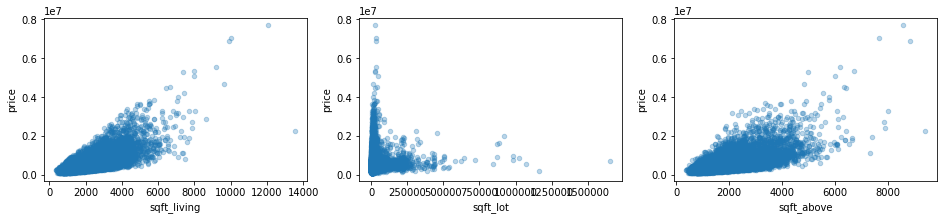

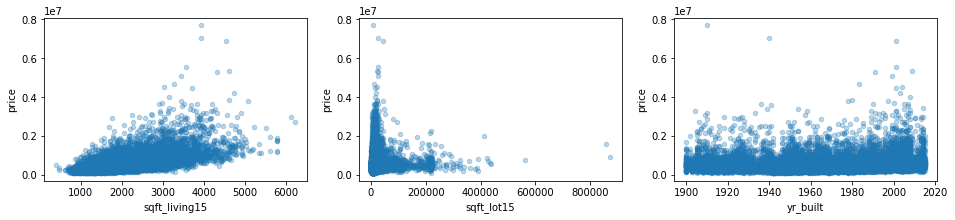

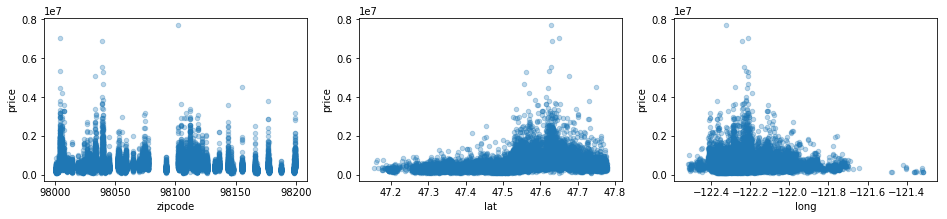

In [14]:
#Plotting potential continuous variables

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list = ['sqft_living','sqft_lot','sqft_above']

for xcol, ax in zip(con_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
con_list2 =['sqft_living15','sqft_lot15','yr_built']

for xcol, ax in zip(con_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)
    
#Plotting zipcode

fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,3))
geo_list = ['zipcode','lat','long']

for xcol, ax in zip(geo_list, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3)


Observation: From the scattered plots above, we can tell sqft_living, sqft_above, sqft_living15 have positive correlation with house price, while yr_built and zipcode do not have obvious relationship with house price. Also from the plot, we can tell that the shape of sqft_living and sqft_living15 are similar while sqft_lot and sqft_lot15 are very similar too. So probably these two sets of variables are highly correlated.

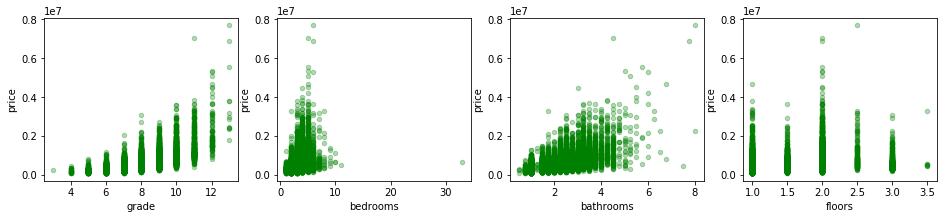

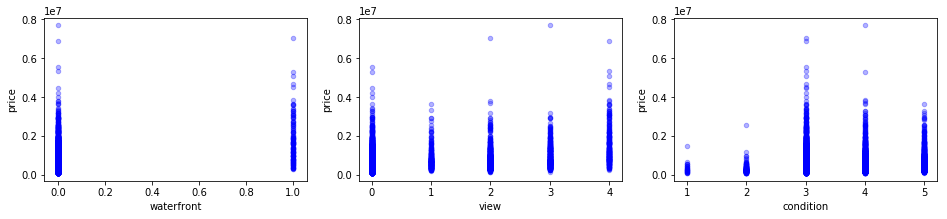

In [15]:
#Plotting other variables. Waterfront is clearly categorical values with binominal values. 
#While view, condition, grade, bedrooms, bathrooms, and floors present actual numerical values so we can either keep them numerical or transform them into categorical values. 

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
cat_list1 = ['grade','bedrooms', 'bathrooms','floors']


for xcol, ax in zip(cat_list1, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='g')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))    
cat_list2=['waterfront', 'view', 'condition']
for xcol, ax in zip(cat_list2, axes):
    kcdata.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.3, color='b')

## Turn condition to dummy columns

In [16]:

kcdata['view']=kcdata['view'].fillna(0)
kcdata['view'] = kcdata['view'].astype(int)


In [17]:
view_dummies = pd.get_dummies(kcdata['view'], prefix='view')


In [18]:
condition_dummies = pd.get_dummies(kcdata['condition'], prefix='con')

In [19]:
kcdata=pd.concat([kcdata,view_dummies,condition_dummies], axis=1)

In [20]:
kcdata[['condition','con_1','con_2','con_3','con_4','con_5']].head(20)

,condition,con_1,con_2,con_3,con_4,con_5
0,3,0,0,1,0,0
1,3,0,0,1,0,0
2,3,0,0,1,0,0
3,5,0,0,0,0,1
4,3,0,0,1,0,0
5,3,0,0,1,0,0
6,3,0,0,1,0,0
7,3,0,0,1,0,0
8,3,0,0,1,0,0
9,3,0,0,1,0,0


## Convert Waterfront to binominal 

In [21]:

kcdata['waterfront'] = kcdata['waterfront'].astype('category')
kcdata['waterfront'].cat.codes
waterfront_dummy = pd.get_dummies(kcdata['waterfront'], prefix ='waterfront')


## Create Bins for grade, bedrooms, bathrooms, years and floors

Although grade, bedrooms, bathrooms and floors are numerical values, it is diffidult to justify a linear pattern between these variables and target here. For example, grade 2 may not mean it is twice better than grade 1, or worse. It might make sense to restructure data into bins so that they are treated as categorical variables.

#### GRADE

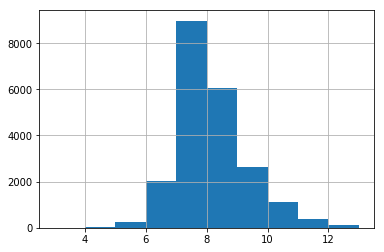

In [22]:
kcdata['grade'].describe()
kcdata['grade'].hist()

In [23]:
bins = [3,7,8,10,13]
bins_grade = pd.cut(kcdata['grade'],bins)

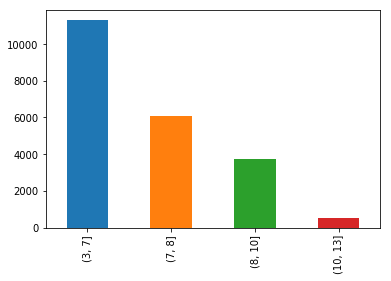

In [24]:
bins_grade.value_counts().plot(kind='bar')

In [25]:
bins_grade = bins_grade.cat.as_unordered()
grade_dummy = pd.get_dummies(bins_grade, prefix='grade')

#### BEDROOMS

In [26]:
kcdata['bedrooms'].describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

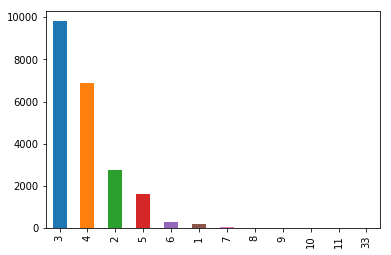

In [27]:
kcdata['bedrooms'].value_counts().plot(kind='bar')

There might be an outlier 33 in the bedroom variable. 

In [28]:
#The observation doesn't make sense, a house with 33 bedrooms only have 1040 sqft above the basement.
kcdata[kcdata['bedrooms']==33].sqft_above

15856    1040
Name: sqft_above, dtype: int64

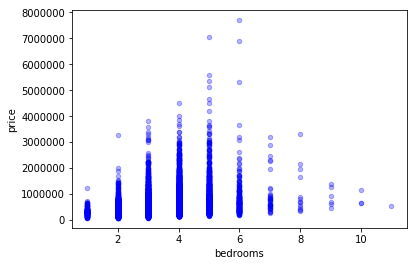

In [29]:
#Remove the max value from bedrooms
o = kcdata['bedrooms'].max()
kcdata = kcdata[kcdata['bedrooms']< o]
kcdata.plot(kind='scatter', x='bedrooms', y='price', alpha=0.3, color='b');


In [30]:
kcdata['bedrooms'].describe()

count    21596.000000
mean         3.371828
std          0.904114
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64

In [31]:
bins = [1,2,3,4,11]
bins_bedroom = pd.cut(kcdata['bedrooms'],bins)
bins_bedroom = bins_bedroom.cat.as_unordered()
bedroom_dummy = pd.get_dummies(bins_bedroom, prefix='bedroom')

#### BATHROOMS

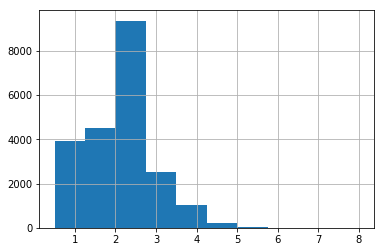

In [32]:
kcdata['bathrooms'].hist()
#kcdata['bathrooms'].value_counts();

The definition of 'bathrooms' is the number of bathrooms per bedrooms. Normally a residential building have 0.5-2 bathrooms per bedroom. So 3-8 bathrooms per bedroom may suggest there are different kinds of buildings. We can investigate the sqft_above and price to see if any outliers. 

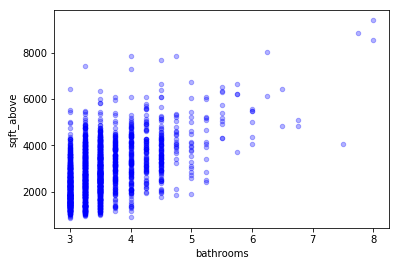

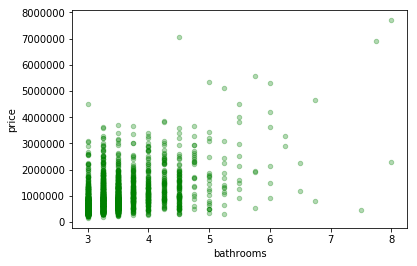

In [33]:
kcdata[kcdata['bathrooms']>=3].groupby('bathrooms').sqft_above.mean()
b = kcdata[kcdata['bathrooms']>=3]
b.plot(kind='scatter', x='bathrooms', y='sqft_above', alpha=0.3, color='b')
b.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


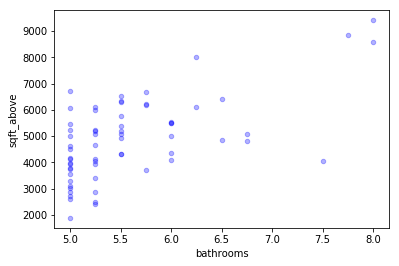

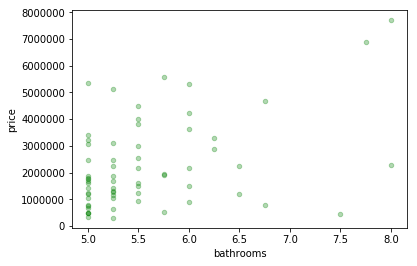

In [34]:
#Check bathrooms >5. 
kcdata[kcdata['bathrooms']>=5].groupby('bathrooms').sqft_above.mean()
a = kcdata[kcdata['bathrooms']>= 5]
a.plot(kind='scatter', x='bathrooms', y='sqft_above', alpha=0.3, color='b')
a.plot(kind='scatter', x='bathrooms', y='price', alpha=0.3, color='g')


We will create bins for bathrooms for now. 

In [35]:
bins = [0.5,1.5,2,2.5,5,8]
bins_bathroom = pd.cut(kcdata['bathrooms'],bins)
bins_bathroom = bins_bathroom.cat.as_unordered()
bathroom_dummy = pd.get_dummies(bins_bathroom, prefix='bathroom')

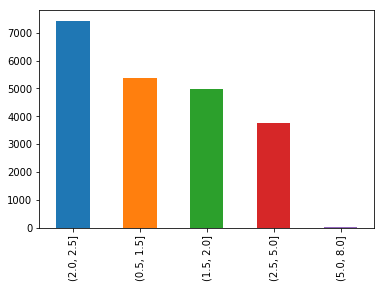

In [36]:
bins_bathroom.value_counts().plot(kind='bar')

#### FLOORS

In [37]:
kcdata['floors'].describe()

count    21596.000000
mean         1.494119
std          0.539685
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

In [38]:
bins = [0,1,1.5,2,3.5]
bins_floors = pd.cut(kcdata['floors'],bins)
bins_floors = bins_floors.cat.as_unordered()
floors_dummy = pd.get_dummies(bins_floors, prefix = 'floors')


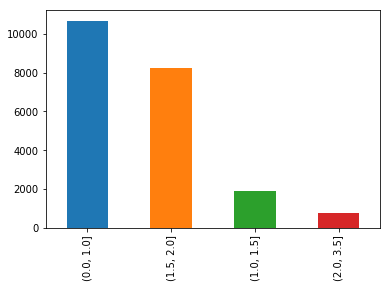

In [39]:
bins_floors.value_counts().plot(kind='bar')

#### Year Built

In [40]:
kcdata['yr_built'].describe()

count    21596.000000
mean      1971.000787
std         29.375460
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

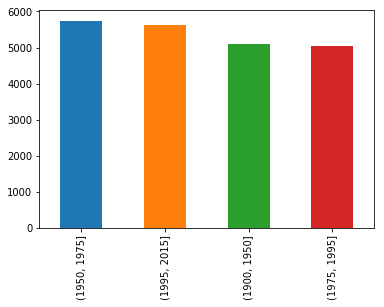

In [41]:
bins = [1900,1950,1975,1995,2015]
bins_year = pd.cut(kcdata['yr_built'],bins)
bins_year = bins_year.cat.as_unordered()
bins_year.head()
year_dummy=pd.get_dummies(bins_year, prefix='year')

bins_year.value_counts().plot(kind='bar')

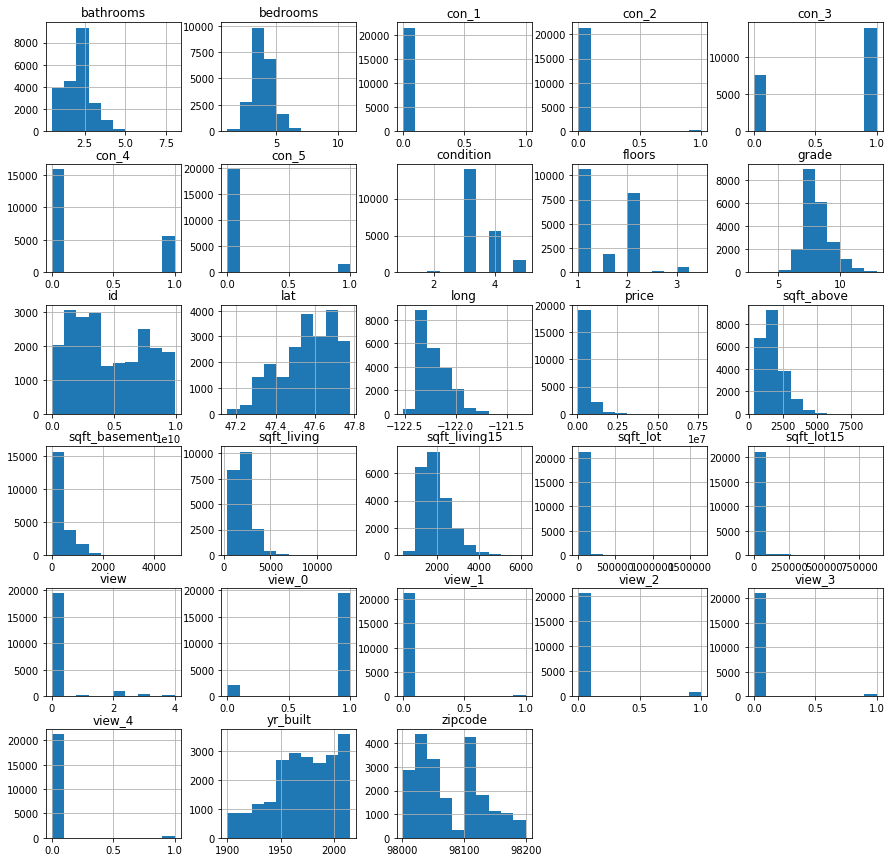

In [42]:
kcdata.hist(figsize=[15,15]);

## Correlation Matrix

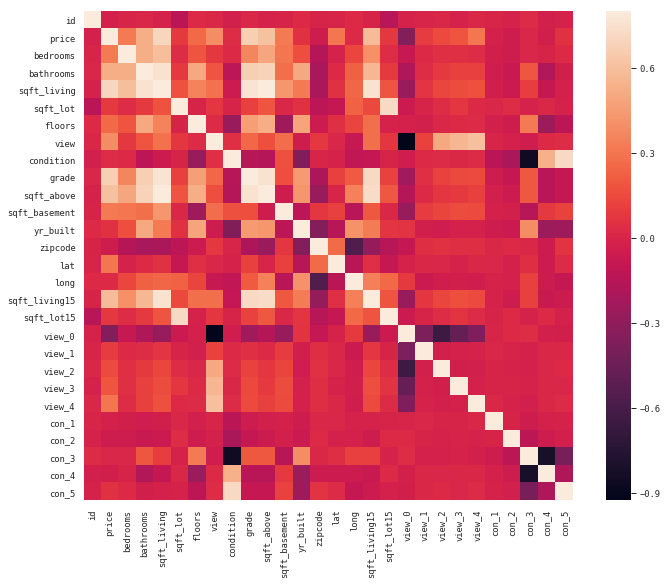

In [43]:
sns.set(context='paper', font='monospace')
corrmat = kcdata.corr()


f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.8, square=True);

Analyzing the heatmap, the variables that are highly correlated to price are:
* sqft_living
* sqft_above
* grade

Independent variables which are highly correlated with each other:

* sqft_living with sqft_living15, bathroom, grade, sqft_above
* grade with bathroom, sqft_above, sqft_living15, sqft_living

## Check Multicolinearity 

In [44]:
## Check Multicolinearity 

kcdata_set = kcdata.iloc[:,3:-1]
kcdata_set.head()
kcdata_set.corr()
abs(kcdata_set.corr()) > 0.75;

The correlation matrix confirms the observation that sqft_living are highly correlated with bathrooms, grade, sqft_above, sqft_living15.

Multicolinearity exists here.

We will drop sqft_living15, sqft_lot15 because they are highly correlated with sqft_living and sqft_lot, and also zipcode, lat, long.

## Feature Scaling and Normalization

In [103]:
#kcdata.info()

kcdata_set = kcdata.drop(columns=['sqft_living15','sqft_lot15','zipcode','lat','long'],axis=1)

In [104]:
kcdata_set = pd.concat([kcdata_set,bedroom_dummy, bathroom_dummy, grade_dummy, waterfront_dummy, floors_dummy, year_dummy], axis=1)
kcdata_set.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,waterfront_0.0,waterfront_1.0,"floors_(0.0, 1.0]","floors_(1.0, 1.5]","floors_(1.5, 2.0]","floors_(2.0, 3.5]","year_(1900, 1950]","year_(1950, 1975]","year_(1975, 1995]","year_(1995, 2015]"
0,7.129301e+09,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6.414100e+09,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,...,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,5.631500e+09,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.487201e+09,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.954401e+09,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,...,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [105]:
kcdata_set.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21597 entries, 0 to 21596
Data columns (total 48 columns):
id                     21596 non-null float64
date                   21596 non-null datetime64[ns]
price                  21596 non-null float64
bedrooms               21596 non-null float64
bathrooms              21596 non-null float64
sqft_living            21596 non-null float64
sqft_lot               21596 non-null float64
floors                 21596 non-null float64
waterfront             21596 non-null category
view                   21596 non-null float64
condition              21596 non-null float64
grade                  21596 non-null float64
sqft_above             21596 non-null float64
sqft_basement          21596 non-null float64
yr_built               21596 non-null float64
view_0                 21596 non-null float64
view_1                 21596 non-null float64
view_2                 21596 non-null float64
view_3                 21596 non-null float64
view_4   

 
Variables with lepto kurtosis: price, sqft_lot
Variables with either positive or negative Skewness: sqft_above, sqft_living

We will perform log transformation to variables with skewness and then do mean normalization. 

### Log Transformation on sqft_above and sqft_living

In [48]:
kcdata_log = pd.DataFrame([])
kcdata_log['sqft_above']=np.log(kcdata_set['sqft_above'])
kcdata_log['sqft_living']=np.log(kcdata_set['sqft_living'])
kcdata_log['price']=np.log(kcdata_set['price'])

In [50]:
basement = kcdata_set['sqft_basement']
lot = kcdata_set['sqft_lot']
logabove = kcdata_log['sqft_above']
logliving = kcdata_log['sqft_living']
logprice = kcdata_log['price']


scaled_basement= (basement - min(basement))/(max(basement) - min(basement))
scaled_lot = (lot - min(lot))/(max(lot) - min(lot))
scaled_above = (logabove - np.mean(logabove))/np.sqrt(np.var(logabove))
scaled_living = (logliving - np.mean(logliving))/np.sqrt(np.var(logliving))
scaled_price = (logprice - np.mean(logprice))/np.sqrt(np.var(logprice))


kcdata_set['price']=scaled_price
kcdata_set['sqft_living']=scaled_living
kcdata_set['sqft_above']=scaled_above
kcdata_set['sqft_lot']=scaled_lot
kcdata_set['sqft_basement']=scaled_basement

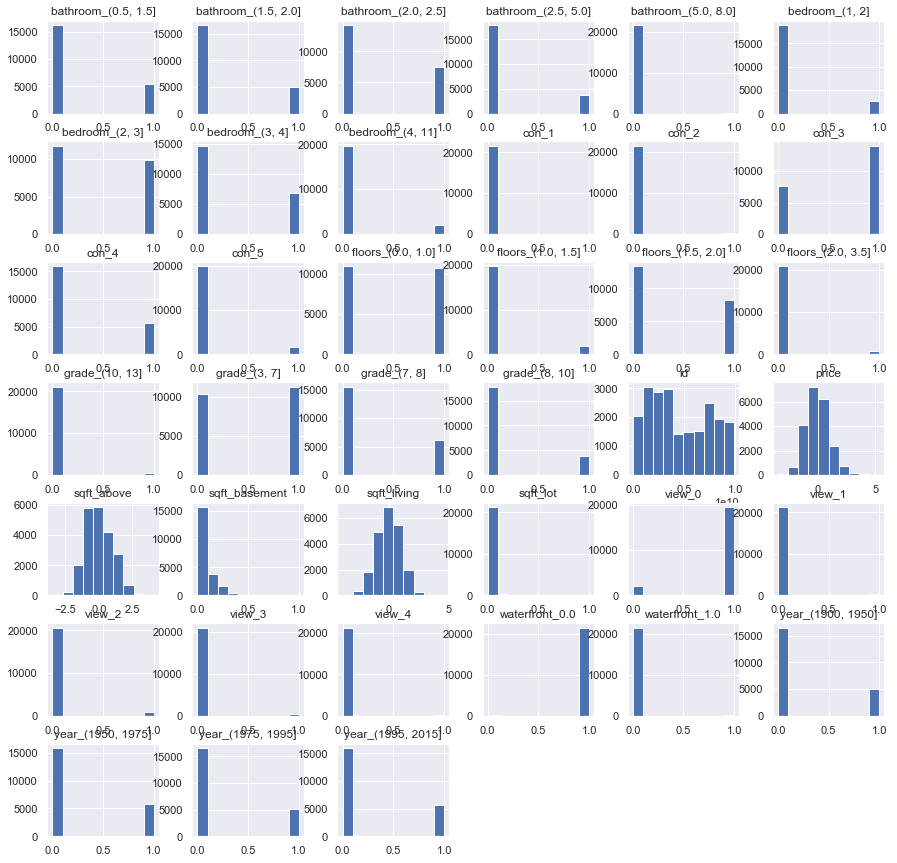

In [102]:
kcdata_set.hist(figsize=[15,15]);

In [130]:
kcdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 30 columns):
id               21596 non-null int64
date             21596 non-null datetime64[ns]
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null float64
waterfront       21596 non-null category
view             21596 non-null int64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null int64
sqft_basement    21596 non-null float64
yr_built         21596 non-null int64
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
sqft_living15    21596 non-null int64
sqft_lot15       21596 non-null int64
view_0           21596 non-null uint8
view_1           21596 non-null uint8
view_2           21596 non-null

There might be too many dummy variables. 

Resources: https://medium.com/vickdata/four-feature-types-and-how-to-transform-them-for-machine-learning-8693e1c24e80

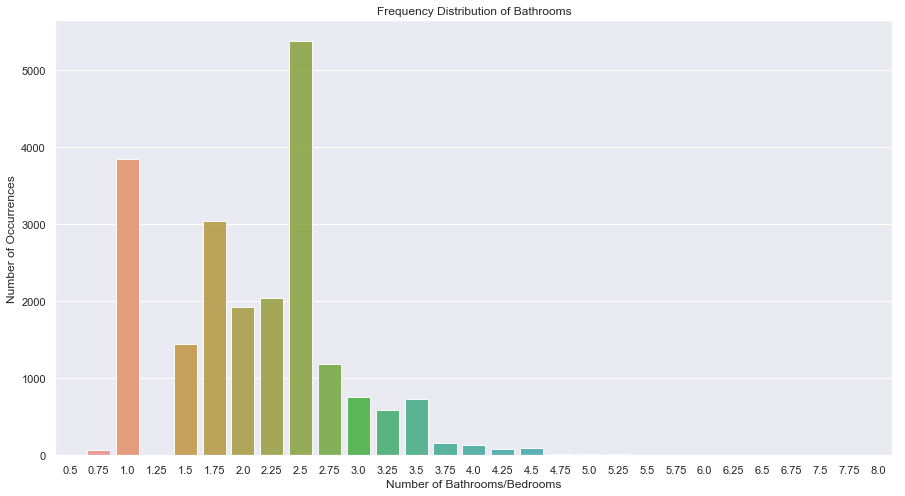

In [53]:
#Value Counts 
#bathroomsNumber - of bathrooms/bedrooms

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
bathroom_count = kcdata['bathrooms'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
sns.barplot(bathroom_count.index, bathroom_count.values, alpha=0.9)

plt.title('Frequency Distribution of Bathrooms')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Bathrooms/Bedrooms', fontsize=12)
plt.show()

## Part III: Linear Regression

### Simple Linear Regression on area variables

In [114]:
import statsmodels.api as sms
from statsmodels.formula.api import ols

In [115]:
data_ols = kcdata_set.iloc[:,2:]
data_ols.dropna(inplace=True)

In [169]:
data_ols.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'view_0', 'view_1', 'view_2', 'view_3',
       'view_4', 'con_1', 'con_2', 'con_3', 'con_4', 'con_5', 'bedroom_(1, 2]',
       'bedroom_(2, 3]', 'bedroom_(3, 4]', 'bedroom_(4, 11]',
       'bathroom_(0.5, 1.5]', 'bathroom_(1.5, 2.0]', 'bathroom_(2.0, 2.5]',
       'bathroom_(2.5, 5.0]', 'bathroom_(5.0, 8.0]', 'grade_(3, 7]',
       'grade_(7, 8]', 'grade_(8, 10]', 'grade_(10, 13]', 'waterfront_0.0',
       'waterfront_1.0', 'floors_(0.0, 1.0]', 'floors_(1.0, 1.5]',
       'floors_(1.5, 2.0]', 'floors_(2.0, 3.5]', 'year_(1900, 1950]',
       'year_(1950, 1975]', 'year_(1975, 1995]', 'year_(1995, 2015]'],
      dtype='object')

In [116]:
X = data_ols.sqft_living
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                 1.124e+05
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        21:44:19   Log-Likelihood:            -3.0010e+05
No. Observations:               21596   AIC:                         6.002e+05
Df Residuals:                   21595   BIC:                         6.002e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sqft_living   263.1616      0.785    335.309      0.000     261.623     264.700
==============================================================================
Omnibus:                    16022.057   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           689078.297
Skew:                           3.128   Prob(JB):                         0.00
Kurtosis:                      29.956   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared is very high which means the size of the living room variable can explain 83.9% of the variance of price already. 

In [117]:
X = data_ols.sqft_basement
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                 1.227e+04
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        21:46:19   Log-Likelihood:            -3.1495e+05
No. Observations:               21596   AIC:                         6.299e+05
Df Residuals:                   21595   BIC:                         6.299e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sqft_basement   749.8078      6.770    110.758      0.000     736.538     763.077
==============================================================================
Omnibus:                     7593.987   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96369.114
Skew:                           1.329   Prob(JB):                         0.00
Kurtosis:                      13.001   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
X = data_ols.sqft_above
y = data_ols.price

model = sms.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                 8.544e+04
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        21:46:31   Log-Likelihood:            -3.0253e+05
No. Observations:               21596   AIC:                         6.051e+05
Df Residuals:                   21595   BIC:                         6.051e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sqft_above   296.1810      1.013    292.299      0.000     294.195     298.167
==============================================================================
Omnibus:                    15076.472   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           548702.683
Skew:                           2.903   Prob(JB):                         0.00
Kurtosis:                      27.001   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The square footage of house apart from basement seems to be significant to house price too. 

#### Let's try to put area related variables in a multiple regression model

In [175]:
import statsmodels.formula.api as smf

model = 'price ~ sqft_above + sqft_basement + grade + bedrooms + yr_built + floors + waterfront + bathrooms'
smf.ols(formula=model, data=data_ols).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     4891.
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        23:28:28   Log-Likelihood:            -2.9621e+05
No. Observations:               21596   AIC:                         5.924e+05
Df Residuals:                   21587   BIC:                         5.925e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          7.036e+06   1.24e+05     56.901      0.000    6.79e+06    7.28e+06
waterfront[T.1.0]  7.514e+05   1.84e+04     40.823      0.000    7.15e+05    7.88e+05
sqft_above          167.8139      3.481     48.205      0.000     160.990     174.638
sqft_basement       187.5786      4.554     41.194      0.000     178.653     196.504
grade              1.321e+05   2175.655     60.710      0.000    1.28e+05    1.36e+05
bedrooms          -4.366e+04   2124.327    -20.553      0.000   -4.78e+04   -3.95e+04
yr_built          -3992.5492     64.858    -61.558      0.000   -4119.676   -3865.423
floors             2.382e+04   3737.141      6.374      0.000    1.65e+04    3.11e+04
bathrooms          5.411e+04   3500.140     15.458      0.000    4.72e+04     6.1e+04
==============================================================================
Omnibus:                    15815.597   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1009037.614
Skew:                           2.926   Prob(JB):                         0.00
Kurtosis:                      35.972   Cond. No.                     2.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interesting! The model result is worse than simple linear model. There are strong multicollinearity which reduce model quality.

#### Let's put all variables into the model and let algorithm decide which variable to keep.

In [58]:
predictors = data_ols.drop('price', axis=1)
X = predictors
y = data_ols['price']

In [59]:
import statsmodels.api as sm
#from statsmodels.formula.api import ols

X_int = sm.add_constant(predictors)

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     1110.
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        21:16:00   Log-Likelihood:                -19923.
No. Observations:               21596   AIC:                         3.991e+04
Df Residuals:                   21562   BIC:                         4.018e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.623e+11    7.5e+11      0.483      0.629   -1.11e+12    1.83e+12
sqft_living             0.4384      0.023     18.961      0.000       0.393       0.484
sqft_lot               -0.0808      0.171     -0.472      0.637      -0.416       0.254
sqft_above             -0.0214      0.021     -1.020      0.308      -0.062       0.020
sqft_basement           0.2658      0.125      2.123      0.034       0.020       0.511
view_0               7.447e+10   1.54e+11      0.483      0.629   -2.28e+11    3.77e+11
view_1               7.447e+10   1.54e+11      0.483      0.629   -2.28e+11    3.77e+11
view_2               7.447e+10   1.54e+11      0.483      0.629   -2.28e+11    3.77e+11
view_3               7.447e+10   1.54e+11      0.483      0.629   -2.28e+11    3.77e+11
view_4               7.447e+10   1.54e+11      0.483      0.629   -2.28e+11    3.77e+11
con_1                2.326e+10   4.82e+10      0.483      0.629   -7.12e+10    1.18e+11
con_2                2.326e+10   4.82e+10      0.483      0.629   -7.12e+10    1.18e+11
con_3                2.326e+10   4.82e+10      0.483      0.629   -7.12e+10    1.18e+11
con_4                2.326e+10   4.82e+10      0.483      0.629   -7.12e+10    1.18e+11
con_5                2.326e+10   4.82e+10      0.483      0.629   -7.12e+10    1.18e+11
bedroom_(1, 2]          0.0505      0.046      1.105      0.269      -0.039       0.140
bedroom_(2, 3]         -0.0921      0.046     -1.998      0.046      -0.182      -0.002
bedroom_(3, 4]         -0.1808      0.048     -3.805      0.000      -0.274      -0.088
bedroom_(4, 11]        -0.2023      0.050     -4.052      0.000      -0.300      -0.104
bathroom_(0.5, 1.5]     0.7918      0.305      2.596      0.009       0.194       1.390
bathroom_(1.5, 2.0]     0.9227      0.305      3.024      0.002       0.325       1.521
bathroom_(2.0, 2.5]     0.9106      0.305      2.983      0.003       0.312       1.509
bathroom_(2.5, 5.0]     1.0514      0.305      3.442      0.001       0.453       1.650
bathroom_(5.0, 8.0]     1.4059      0.321      4.381      0.000       0.777       2.035
grade_(3, 7]           -0.0957      0.611     -0.157      0.876      -1.293       1.102
grade_(7, 8]            0.3441      0.611      0.563      0.573      -0.854       1.542
grade_(8, 10]           0.8607      0.611      1.408      0.159      -0.338       2.059
grade_(10, 13]          1.5088      0.612      2.465      0.014       0.309       2.709
waterfront_0.0      -5.515e+11   1.14e+12     -0.483      0.629   -2.79e+12    1.69e+12
waterfront_1.0      -5.515e+11   1.14e+12     -0.483      0.629   -2.79e+12    1.69e+12
floors_(0.0, 1.0]    9.141e+10   1.89e+11      0.483      0.629    -2.8e+11    4.62e+11
floors_(1.0, 1.5]    9.141e+10   1.89e+11      0.483      0.629    -2.8e+11    4.62e+11
flo

In [60]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [123]:
X = predictors
y = data_ols['price']

In [124]:
result = stepwise_selection(X, y, verbose = True)
print(result)

Add  grade_(3, 7]                   with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  grade_(10, 13]                 with p-value 0.0
Add  waterfront_0.0                 with p-value 0.0
Add  grade_(8, 10]                  with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  year_(1900, 1950]              with p-value 0.0
Add  waterfront_1.0                 with p-value 0.0
Add  bathroom_(5.0, 8.0]            with p-value 9.07081e-120
Add  view_0                         with p-value 4.58738e-94
Add  year_(1950, 1975]              with p-value 3.58784e-70
Add  floors_(2.0, 3.5]              with p-value 2.02309e-51
Add  bathroom_(2.5, 5.0]            with p-value 4.26912e-38
Add  view_4                         with p-value 5.0174e-35
Add  con_5                          with p-value 2.97227e-21
Add  bedroom_(3, 4]                 with p-value 1.68518e-16
Add  bedroom_(1, 2]                 with p-value 2.67061e-10
Add  con_4                 

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  sqft_living                    with p-value 4.63616e-05
Add  bedroom_(4, 11]                with p-value 0.00016167
Add  floors_(1.5, 2.0]              with p-value 0.000140696
Add  bathroom_(1.5, 2.0]            with p-value 0.000255949
Add  con_3                          with p-value 0.00653879
['grade_(3, 7]', 'sqft_above', 'grade_(10, 13]', 'grade_(8, 10]', 'sqft_basement', 'year_(1900, 1950]', 'waterfront_1.0', 'bathroom_(5.0, 8.0]', 'view_0', 'year_(1950, 1975]', 'floors_(2.0, 3.5]', 'bathroom_(2.5, 5.0]', 'view_4', 'con_5', 'bedroom_(3, 4]', 'bedroom_(1, 2]', 'con_4', 'sqft_lot', 'view_2', 'sqft_living', 'bedroom_(4, 11]', 'floors_(1.5, 2.0]', 'bathroom_(1.5, 2.0]', 'con_3']


In [69]:
predictors[result];

In [70]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

X_int = sm.add_constant(predictors[result])

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     1590.
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        21:21:36   Log-Likelihood:                -19938.
No. Observations:               21596   AIC:                         3.992e+04
Df Residuals:                   21572   BIC:                         4.012e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.5868      0.102     15.590      0.000       1.387       1.786
grade_(3, 7]           -0.9568      0.016    -59.205      0.000      -0.988      -0.925
sqft_basement           0.3889      0.062      6.314      0.000       0.268       0.510
year_(1900, 1950]      -0.1640      0.066     -2.484      0.013      -0.293      -0.035
grade_(7, 8]           -0.5173      0.014    -36.677      0.000      -0.545      -0.490
view_0                 -0.2842      0.022    -12.720      0.000      -0.328      -0.240
grade_(10, 13]          0.6503      0.031     21.146      0.000       0.590       0.711
sqft_living             0.4057      0.009     46.600      0.000       0.389       0.423
year_(1975, 1995]      -0.7935      0.066    -11.967      0.000      -0.923      -0.664
floors_(2.0, 3.5]       0.2861      0.024     12.144      0.000       0.240       0.332
year_(1995, 2015]      -0.7618      0.066    -11.463      0.000      -0.892      -0.632
con_5                   0.5765      0.046     12.533      0.000       0.486       0.667
bathroom_(2.5, 5.0]     0.1334      0.013     10.198      0.000       0.108       0.159
year_(1950, 1975]      -0.5362      0.066     -8.090      0.000      -0.666      -0.406
bedroom_(1, 2]          0.2129      0.017     12.600      0.000       0.180       0.246
bathroom_(0.5, 1.5]    -0.1259      0.013     -9.400      0.000      -0.152      -0.100
bedroom_(2, 3]          0.0831      0.010      8.146      0.000       0.063       0.103
floors_(0.0, 1.0]      -0.0926      0.012     -7.625      0.000      -0.116      -0.069
view_4                  0.2426      0.046      5.235      0.000       0.152       0.333
con_4                   0.4664      0.044     10.549      0.000       0.380       0.553
waterfront_0.0         -0.6135      0.062     -9.949      0.000      -0.734      -0.493
bathroom_(5.0, 8.0]     0.4727      0.097      4.880      0.000       0.283       0.663
con_3                   0.4023      0.044      9.152      0.000       0.316       0.488
view_2                 -0.0956      0.029     -3.309      0.001      -0.152      -0.039
==============================================================================
Omnibus:                       84.194   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.082
Skew:                          -0.110   Prob(JB):                     3.72e-21
Kurtosis:                       3.237   Cond. No.                         78.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model produced by step-wise selection keeps variables with p-value < 0.05. However, the adjusted R-square is only 0.629 which is worse than the single variable model.

#### Let's use some common sense... since sqft_living along explains majority of the variance, how about adding bedrooms and waterfront to the model?

In [165]:
import statsmodels.api as sm
#from statsmodels.formula.api import ols
y=data_ols['price']
predictors = data_ols[['sqft_living']]
X_int = sm.add_constant(predictors)

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        23:24:22   Log-Likelihood:            -3.0005e+05
No. Observations:               21596   AIC:                         6.001e+05
Df Residuals:                   21594   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.401e+04   4410.123     -9.980      0.000   -5.27e+04   -3.54e+04
sqft_living   280.8688      1.939    144.820      0.000     277.067     284.670
==============================================================================
Omnibus:                    14801.492   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542642.481
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Use sklearn

#You have to use numerical values in sklearn... has to transform to dummy variables...
https://www.scikit-yb.org/en/latest/api/features/rfecv.html

In [146]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [160]:
predictors = data_ols.drop('price', axis=1)
X = predictors
y = data_ols['price']

linreg = LinearRegression()
selector = RFE(linreg,n_features_to_select=10)
selector = selector.fit(X,y)

In [161]:
data_ols.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'view_0', 'view_1', 'view_2', 'view_3',
       'view_4', 'con_1', 'con_2', 'con_3', 'con_4', 'con_5', 'bedroom_(1, 2]',
       'bedroom_(2, 3]', 'bedroom_(3, 4]', 'bedroom_(4, 11]',
       'bathroom_(0.5, 1.5]', 'bathroom_(1.5, 2.0]', 'bathroom_(2.0, 2.5]',
       'bathroom_(2.5, 5.0]', 'bathroom_(5.0, 8.0]', 'grade_(3, 7]',
       'grade_(7, 8]', 'grade_(8, 10]', 'grade_(10, 13]', 'waterfront_0.0',
       'waterfront_1.0', 'floors_(0.0, 1.0]', 'floors_(1.0, 1.5]',
       'floors_(1.5, 2.0]', 'floors_(2.0, 3.5]', 'year_(1900, 1950]',
       'year_(1950, 1975]', 'year_(1975, 1995]', 'year_(1995, 2015]'],
      dtype='object')

In [162]:
selector.support_

array([False, False, False, False, False, False,  True, False, False,
       False, False, False,  True,  True, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True, False, False, False, False])

In [163]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[-1.44979175e+17 -2.89958350e+17 -1.44979175e+17  1.44979175e+17
  2.89958350e+17 -1.69766873e+05 -3.65703846e+17 -3.65703846e+17
 -3.65703846e+17 -3.65703846e+17]
6.556621960236466e+17


In [164]:
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)
selected_columns

Index(['view', 'view_0', 'view_1', 'view_3', 'view_4', 'con_1',
       'floors_(0.0, 1.0]', 'floors_(1.0, 1.5]', 'floors_(1.5, 2.0]',
       'floors_(2.0, 3.5]'],
      dtype='object')

In [157]:
X_int = sm.add_constant(predictors[selected_columns])

model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     822.9
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        23:21:22   Log-Likelihood:            -3.0450e+05
No. Observations:               21596   AIC:                         6.090e+05
Df Residuals:                   21587   BIC:                         6.091e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -6.978e+17   2.59e+17     -2.695      0.007   -1.21e+18    -1.9e+17
view              -4.376e+04   2.05e+04     -2.130      0.033    -8.4e+04   -3500.441
view_0             -3.78e+05    3.7e+04    -10.217      0.000    -4.5e+05   -3.05e+05
view_3             2.171e+05   3.08e+04      7.043      0.000    1.57e+05    2.77e+05
view_4             7.352e+05   5.05e+04     14.548      0.000    6.36e+05    8.34e+05
floors_(0.0, 1.0]  6.978e+17   2.59e+17      2.695      0.007     1.9e+17    1.21e+18
floors_(1.0, 1.5]  6.978e+17   2.59e+17      2.695      0.007     1.9e+17    1.21e+18
floors_(1.5, 2.0]  6.978e+17   2.59e+17      2.695      0.007     1.9e+17    1.21e+18
floors_(2.0, 3.5]  6.978e+17   2.59e+17      2.695      0.007     1.9e+17    1.21e+18
==============================================================================
Omnibus:                    18269.049   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1252024.214
Skew:                           3.678   Prob(JB):                         0.00
Kurtosis:                      39.569   Cond. No.                     4.00e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.09e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### 

In [ ]:
"""


formula = "price ~ bedrooms + bathrooms + sqft_above + sqft_lot + sqft_basement + sqft_living + yr_built + grade + con_1+con_2+con_3+con_4+con_5"
model = ols(formula=formula, data = data_ols).fit()
model.summary()

"""

## Cross-Validation